# Домашняя работа 1


## Описание

В этой домашней работе вы должны применить знания по многослойным нейроным сетям

- Для простоты попробуем обучить сначала однослойный перцептрон
- Решать будем простую задачу бинарной классификации
- Датасет игрушечный -  `load_data()` загружает его


In [1]:
import numpy as np
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Загрузка данных

In [4]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [5]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


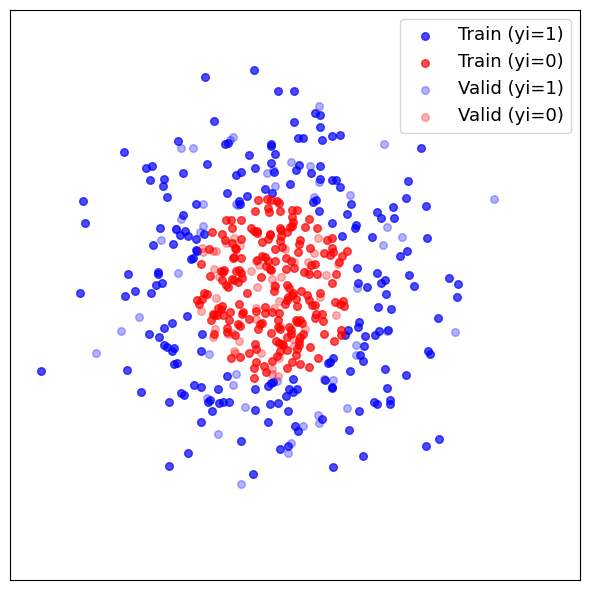

In [5]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## Класс нейросети

Вам необходимо описать простую полносвязную многослойную нейронную сеть

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Input -> hidden (10) -> output (1)
        self.fc1 = nn.Linear(2, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)  # binary classification
        
    def forward(self, X):
        x = self.fc1(X)
        x = self.relu(x)
        x = self.fc2(x)
        return x

##  Функция обучения сети

Необходимо сохранять историю лоссов для последующего сравнения и визуализации.
Также нужно реализовать early stopping. Критерий остановки подбирите на ваше усмотрение.

In [12]:
def train(model, loss_fn, optimizer, n_epochs, batch_size, X_train, y_train):
    history = []
    dataset = TensorDataset(X_train, y_train.view(-1, 1))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        history.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    return history

### Обучите сеть

Обучите сеть три раза - с тремя разными оптимизиторами
Не забудьте переинициализировать сеть заного перед каждой загрузкой. Убедитесь, что вы верно передали параметры сети в оптимизатор

**Подсказка** Лучше объявить три независимых объекта - модель1, модель2 и модель3

In [13]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

n_epochs = 100
batch_size = 32
lr = 0.01

loss_fn = nn.BCEWithLogitsLoss()

# Separate model instances for each optimizer
model_SGD = NeuralNetwork()
model_Adam = NeuralNetwork()
model_RMSProp = NeuralNetwork()

optimizers = {
    'SGD': optim.SGD(model_SGD.parameters(), lr=lr),
    'Adam': optim.Adam(model_Adam.parameters(), lr=lr),
    'RMSProp': optim.RMSprop(model_RMSProp.parameters(), lr=lr)
}

# Train each model and collect loss histories
print("\nTraining with SGD:")
loss_SGD = train(model_SGD, loss_fn, optimizers['SGD'], n_epochs, batch_size, X_train_torch, y_train_torch)
print("\nTraining with Adam:")
loss_Adam = train(model_Adam, loss_fn, optimizers['Adam'], n_epochs, batch_size, X_train_torch, y_train_torch)
print("\nTraining with RMSProp:")
loss_RMSProp = train(model_RMSProp, loss_fn, optimizers['RMSProp'], n_epochs, batch_size, X_train_torch, y_train_torch)


Training with SGD:
Epoch 1/100, Loss: 0.7169
Epoch 2/100, Loss: 0.7151
Epoch 3/100, Loss: 0.7131
Epoch 4/100, Loss: 0.7124
Epoch 5/100, Loss: 0.7101
Epoch 6/100, Loss: 0.7082
Epoch 7/100, Loss: 0.7071
Epoch 8/100, Loss: 0.7056
Epoch 9/100, Loss: 0.7045
Epoch 10/100, Loss: 0.7025
Epoch 11/100, Loss: 0.7020
Epoch 12/100, Loss: 0.7003
Epoch 13/100, Loss: 0.6992
Epoch 14/100, Loss: 0.6984
Epoch 15/100, Loss: 0.6970
Epoch 16/100, Loss: 0.6960
Epoch 17/100, Loss: 0.6944
Epoch 18/100, Loss: 0.6928
Epoch 19/100, Loss: 0.6923
Epoch 20/100, Loss: 0.6905
Epoch 21/100, Loss: 0.6899
Epoch 22/100, Loss: 0.6888
Epoch 23/100, Loss: 0.6879
Epoch 24/100, Loss: 0.6871
Epoch 25/100, Loss: 0.6864
Epoch 26/100, Loss: 0.6853
Epoch 27/100, Loss: 0.6838
Epoch 28/100, Loss: 0.6827
Epoch 29/100, Loss: 0.6823
Epoch 30/100, Loss: 0.6804
Epoch 31/100, Loss: 0.6798
Epoch 32/100, Loss: 0.6796
Epoch 33/100, Loss: 0.6788
Epoch 34/100, Loss: 0.6772
Epoch 35/100, Loss: 0.6767
Epoch 36/100, Loss: 0.6766
Epoch 37/100, Los

### А теперь посмотрим на графики лоссов

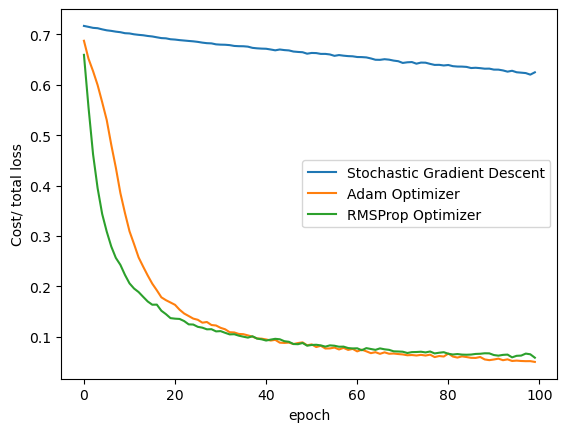

In [14]:
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_RMSProp, label = "RMSProp Optimizer")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

### Инициализация

Теперь проинициализируйте веса в вашей модели: случайно и Ксавьером. Сравните эти две модели на предыдущей задаче.

In [15]:
class RandomNetwork(nn.Module):
    def __init__(self):
        super(RandomNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)
        torch.nn.init.normal_(self.fc1.weight, mean=0, std=1)
        torch.nn.init.normal_(self.fc2.weight, mean=0, std=1)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)
    
    def forward(self, X):
        x = self.fc1(X)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class XavierNetwork(nn.Module):
    def __init__(self):
        super(XavierNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)
    
    def forward(self, X):
        x = self.fc1(X)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [16]:
def train(model, loss_fn, optimizer, n_epochs, batch_size, X_train, y_train):
    history = []
    dataset = TensorDataset(X_train, y_train.view(-1, 1))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        history.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    return history

In [17]:
n_epochs = 100
batch_size = 32
lr = 0.01
loss_fn = nn.BCEWithLogitsLoss()

model_default = NeuralNetwork()
model_random = RandomNetwork()
model_xavier = XavierNetwork()

optimizer_default = optim.Adam(model_default.parameters(), lr=lr)
optimizer_random = optim.Adam(model_random.parameters(), lr=lr)
optimizer_xavier = optim.Adam(model_xavier.parameters(), lr=lr)

print("Training with Default:")
loss_default = train(model_default, loss_fn, optimizer_default, n_epochs, batch_size, X_train_torch, y_train_torch)

print("Training with Random:")
loss_random = train(model_random, loss_fn, optimizer_random, n_epochs, batch_size, X_train_torch, y_train_torch)

print("Training with Xavier:")
loss_xavier = train(model_xavier, loss_fn, optimizer_xavier, n_epochs, batch_size, X_train_torch, y_train_torch)

Training with Default:
Epoch 1/100, Loss: 0.6880
Epoch 2/100, Loss: 0.6554
Epoch 3/100, Loss: 0.6331
Epoch 4/100, Loss: 0.6114
Epoch 5/100, Loss: 0.5852
Epoch 6/100, Loss: 0.5560
Epoch 7/100, Loss: 0.5199
Epoch 8/100, Loss: 0.4789
Epoch 9/100, Loss: 0.4353
Epoch 10/100, Loss: 0.3968
Epoch 11/100, Loss: 0.3609
Epoch 12/100, Loss: 0.3295
Epoch 13/100, Loss: 0.3046
Epoch 14/100, Loss: 0.2809
Epoch 15/100, Loss: 0.2646
Epoch 16/100, Loss: 0.2450
Epoch 17/100, Loss: 0.2329
Epoch 18/100, Loss: 0.2196
Epoch 19/100, Loss: 0.2163
Epoch 20/100, Loss: 0.2059
Epoch 21/100, Loss: 0.1945
Epoch 22/100, Loss: 0.1887
Epoch 23/100, Loss: 0.1800
Epoch 24/100, Loss: 0.1734
Epoch 25/100, Loss: 0.1702
Epoch 26/100, Loss: 0.1690
Epoch 27/100, Loss: 0.1577
Epoch 28/100, Loss: 0.1554
Epoch 29/100, Loss: 0.1554
Epoch 30/100, Loss: 0.1462
Epoch 31/100, Loss: 0.1388
Epoch 32/100, Loss: 0.1410
Epoch 33/100, Loss: 0.1343
Epoch 34/100, Loss: 0.1329
Epoch 35/100, Loss: 0.1342
Epoch 36/100, Loss: 0.1295
Epoch 37/100, 

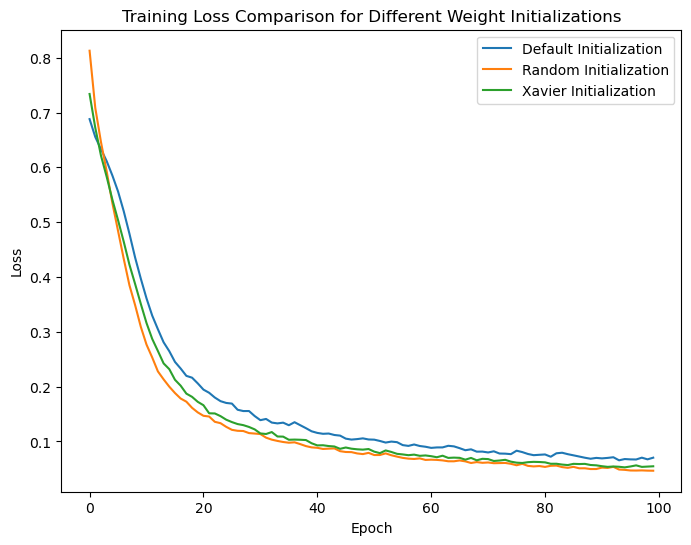

In [18]:
plt.figure(figsize=(8,6))
plt.plot(loss_default, label="Default Initialization")
plt.plot(loss_random, label="Random Initialization")
plt.plot(loss_xavier, label="Xavier Initialization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison for Different Weight Initializations")
plt.legend()
plt.show()

## А теперь решите многоклассовую проблему

Продемонстрируйте свои знания - решите более сложную проблему
Попробуйте разные инициализации, методы оптимизации и кол-во нейронов.

**Найдите лучшие параметры через KFold**

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold

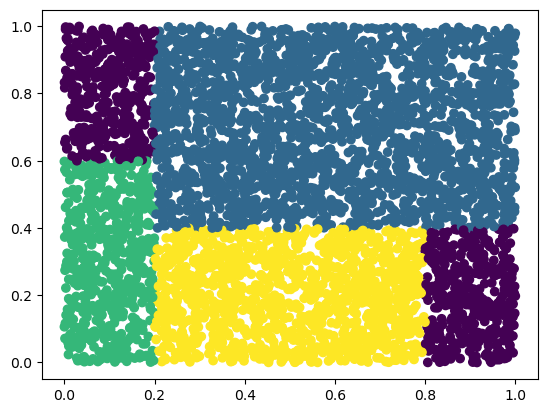

In [20]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)

target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train_data = data[:800]
valid_data = data[800:900]
test_data = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [21]:
def get_features_targets(dataset):
    X = dataset[:, :2].float()
    y = dataset[:, 2].long()
    return X, y

X_train_full, y_train_full = get_features_targets(train_data)
X_valid, y_valid = get_features_targets(valid_data)
X_test, y_test = get_features_targets(test_data)

In [23]:
class AdvancedModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10, output_dim=4, init_method='default'):
        super(AdvancedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        if init_method == 'random':
            torch.nn.init.normal_(self.fc1.weight, mean=0, std=1)
            torch.nn.init.normal_(self.fc2.weight, mean=0, std=1)
        elif init_method == 'xavier':
            torch.nn.init.xavier_uniform_(self.fc1.weight)
            torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [26]:
def train_model(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs):
    history = {'train_loss': [], 'valid_loss': []}
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)
        
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        #print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    return history

In [27]:
# Grid of parameters
hidden_dims = [5, 10, 20]
init_methods = ['default', 'random', 'xavier']
optimizer_names = ['SGD', 'Adam', 'RMSprop']

lr = 0.01
n_epochs = 50
batch_size = 32

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_val_loss = float('inf')
best_params = {}
results = {}

In [28]:
for hidden_dim in hidden_dims:
    for init_method in init_methods:
        for opt_name in optimizer_names:
            fold_losses = []
            # KFold cross validation on the train_data
            for train_index, val_index in kf.split(X_train_full):
                X_train_fold = X_train_full[train_index]
                y_train_fold = y_train_full[train_index]
                X_val_fold = X_train_full[val_index]
                y_val_fold = y_train_full[val_index]
                
                train_dataset = TensorDataset(X_train_fold, y_train_fold)
                val_dataset = TensorDataset(X_val_fold, y_val_fold)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                
                model = AdvancedModel(input_dim=2, hidden_dim=hidden_dim, output_dim=4, init_method=init_method)
                
                if opt_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr)
                elif opt_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif opt_name == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=lr)
                    
                loss_fn = nn.CrossEntropyLoss()
                history = train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs)
                fold_losses.append(history['valid_loss'][-1])
            
            avg_val_loss = np.mean(fold_losses)
            key = f"hidden:{hidden_dim}_init:{init_method}_opt:{opt_name}"
            results[key] = avg_val_loss
            print(f"{key} -> Avg Val Loss: {avg_val_loss:.4f}")
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_params = {
                    'hidden_dim': hidden_dim,
                    'init_method': init_method,
                    'optimizer': opt_name
                }

print("\nBest parameters found:")
print(best_params)
print("With validation loss:", best_val_loss)

hidden:5_init:default_opt:SGD -> Avg Val Loss: 1.0574
hidden:5_init:default_opt:Adam -> Avg Val Loss: 0.3048
hidden:5_init:default_opt:RMSprop -> Avg Val Loss: 0.2443
hidden:5_init:random_opt:SGD -> Avg Val Loss: 0.9673
hidden:5_init:random_opt:Adam -> Avg Val Loss: 0.3679
hidden:5_init:random_opt:RMSprop -> Avg Val Loss: 0.1890
hidden:5_init:xavier_opt:SGD -> Avg Val Loss: 0.9817
hidden:5_init:xavier_opt:Adam -> Avg Val Loss: 0.3364
hidden:5_init:xavier_opt:RMSprop -> Avg Val Loss: 0.2346
hidden:10_init:default_opt:SGD -> Avg Val Loss: 1.0038
hidden:10_init:default_opt:Adam -> Avg Val Loss: 0.2275
hidden:10_init:default_opt:RMSprop -> Avg Val Loss: 0.1774
hidden:10_init:random_opt:SGD -> Avg Val Loss: 0.7846
hidden:10_init:random_opt:Adam -> Avg Val Loss: 0.1688
hidden:10_init:random_opt:RMSprop -> Avg Val Loss: 0.1504
hidden:10_init:xavier_opt:SGD -> Avg Val Loss: 0.9558
hidden:10_init:xavier_opt:Adam -> Avg Val Loss: 0.1498
hidden:10_init:xavier_opt:RMSprop -> Avg Val Loss: 0.1759
h

In [29]:
X_train_final = torch.cat([X_train_full, X_valid], dim=0)
y_train_final = torch.cat([y_train_full, y_valid], dim=0)
final_dataset = TensorDataset(X_train_final, y_train_final)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

final_model = AdvancedModel(input_dim=2, 
                            hidden_dim=best_params['hidden_dim'], 
                            output_dim=4, 
                            init_method=best_params['init_method'])
if best_params['optimizer'] == 'SGD':
    final_optimizer = optim.SGD(final_model.parameters(), lr=lr)
elif best_params['optimizer'] == 'Adam':
    final_optimizer = optim.Adam(final_model.parameters(), lr=lr)
elif best_params['optimizer'] == 'RMSprop':
    final_optimizer = optim.RMSprop(final_model.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss()
final_history = train_model(final_model, final_optimizer, loss_fn, final_loader, test_loader, n_epochs)

In [30]:
final_model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = final_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
test_loss /= len(test_loader)
accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Loss: 0.1141, Test Accuracy: 0.9512


## (Почти) Боевая задача

Перед вами датасет с классификацией алкоголя. Продемонстрируйте свои знания и решите задачу многоклассовой классификации

In [64]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [79]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [80]:
X = df.drop('target', axis=1).values   # features
y = df['target'].values                # target labels (0,1,2)

In [81]:
scaler = MinMaxScaler(feature_range = (0,1))
X_scaled = scaler.fit_transform(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

X_train_val_tensor = torch.tensor(X_train_val, dtype=torch.float32)
y_train_val_tensor = torch.tensor(y_train_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [82]:
class WineClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, init_method='default'):
        super(WineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.init_method = init_method
        self.initialize_weights()
        
    def initialize_weights(self):
        if self.init_method == 'random':
            torch.nn.init.normal_(self.fc1.weight, mean=0, std=1)
            torch.nn.init.normal_(self.fc2.weight, mean=0, std=1)
            torch.nn.init.normal_(self.fc3.weight, mean=0, std=1)
        elif self.init_method == 'xavier':
            torch.nn.init.xavier_uniform_(self.fc1.weight)
            torch.nn.init.xavier_uniform_(self.fc2.weight)
            torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)
        torch.nn.init.zeros_(self.fc3.bias)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [89]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=30):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        history['val_loss'].append(val_loss)
    return history

In [95]:
hidden_dims = [4, 8, 16]
init_methods = ['default', 'random', 'xavier']
optimizer_names = ['SGD', 'Adam', 'RMSprop']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_epochs = 50
batch_size = 16
input_dim = X_train_val_tensor.shape[1]
output_dim = 3
lr = 0.001

results = {}
best_val_loss = float('inf')
best_params = {}
loss_curves = {}  # key: (hidden_dim, init_method, opt_name)

In [96]:
for hidden_dim in hidden_dims:
    for init_method in init_methods:
        for opt_name in optimizer_names:
            fold_train_losses = []
            fold_val_losses = []
            fold_final_losses = []
            for train_index, val_index in kf.split(X_train_val_tensor):
                # Create fold datasets
                X_train_fold = X_train_val_tensor[train_index]
                y_train_fold = y_train_val_tensor[train_index]
                X_val_fold = X_train_val_tensor[val_index]
                y_val_fold = y_train_val_tensor[val_index]
                
                train_dataset = TensorDataset(X_train_fold, y_train_fold)
                val_dataset = TensorDataset(X_val_fold, y_val_fold)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                
                # Initialize the model with current hyperparameters
                model = WineClassifier(input_dim, hidden_dim, output_dim, init_method)
                
                # Select optimizer based on current setting
                if opt_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr)
                elif opt_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif opt_name == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=lr)
                
                loss_fn = nn.CrossEntropyLoss()
                history = train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs)
                fold_train_losses.append(history['train_loss'])
                fold_val_losses.append(history['val_loss'])
                fold_final_losses.append(history['val_loss'][-1])
            
            # Compute average loss curves across folds
            avg_train_losses = np.mean(fold_train_losses, axis=0).tolist()
            avg_val_losses = np.mean(fold_val_losses, axis=0).tolist()
            key = (hidden_dim, init_method, opt_name)
            loss_curves[key] = (avg_train_losses, avg_val_losses)
            avg_final_val_loss = np.mean(fold_final_losses)
            results[key] = avg_final_val_loss
            
            print(f"hidden:{hidden_dim}, init:{init_method}, opt:{opt_name} -> Avg Final Val Loss: {avg_final_val_loss:.4f}")
            
            if avg_final_val_loss < best_val_loss:
                best_val_loss = avg_final_val_loss
                best_params = {
                    'hidden_dim': hidden_dim,
                    'init_method': init_method,
                    'optimizer': opt_name
                }

print("\nBest Hyperparameters Found:")
print(best_params)
print("Best Avg Final Validation Loss:", best_val_loss)

hidden:4, init:default, opt:SGD -> Avg Final Val Loss: 1.0928
hidden:4, init:default, opt:Adam -> Avg Final Val Loss: 0.8939
hidden:4, init:default, opt:RMSprop -> Avg Final Val Loss: 0.7552
hidden:4, init:random, opt:SGD -> Avg Final Val Loss: 1.1841
hidden:4, init:random, opt:Adam -> Avg Final Val Loss: 0.9471
hidden:4, init:random, opt:RMSprop -> Avg Final Val Loss: 0.9041
hidden:4, init:xavier, opt:SGD -> Avg Final Val Loss: 1.1015
hidden:4, init:xavier, opt:Adam -> Avg Final Val Loss: 0.7774
hidden:4, init:xavier, opt:RMSprop -> Avg Final Val Loss: 0.6520
hidden:8, init:default, opt:SGD -> Avg Final Val Loss: 1.0840
hidden:8, init:default, opt:Adam -> Avg Final Val Loss: 0.5769
hidden:8, init:default, opt:RMSprop -> Avg Final Val Loss: 0.5409
hidden:8, init:random, opt:SGD -> Avg Final Val Loss: 1.3291
hidden:8, init:random, opt:Adam -> Avg Final Val Loss: 0.6697
hidden:8, init:random, opt:RMSprop -> Avg Final Val Loss: 0.7465
hidden:8, init:xavier, opt:SGD -> Avg Final Val Loss: 

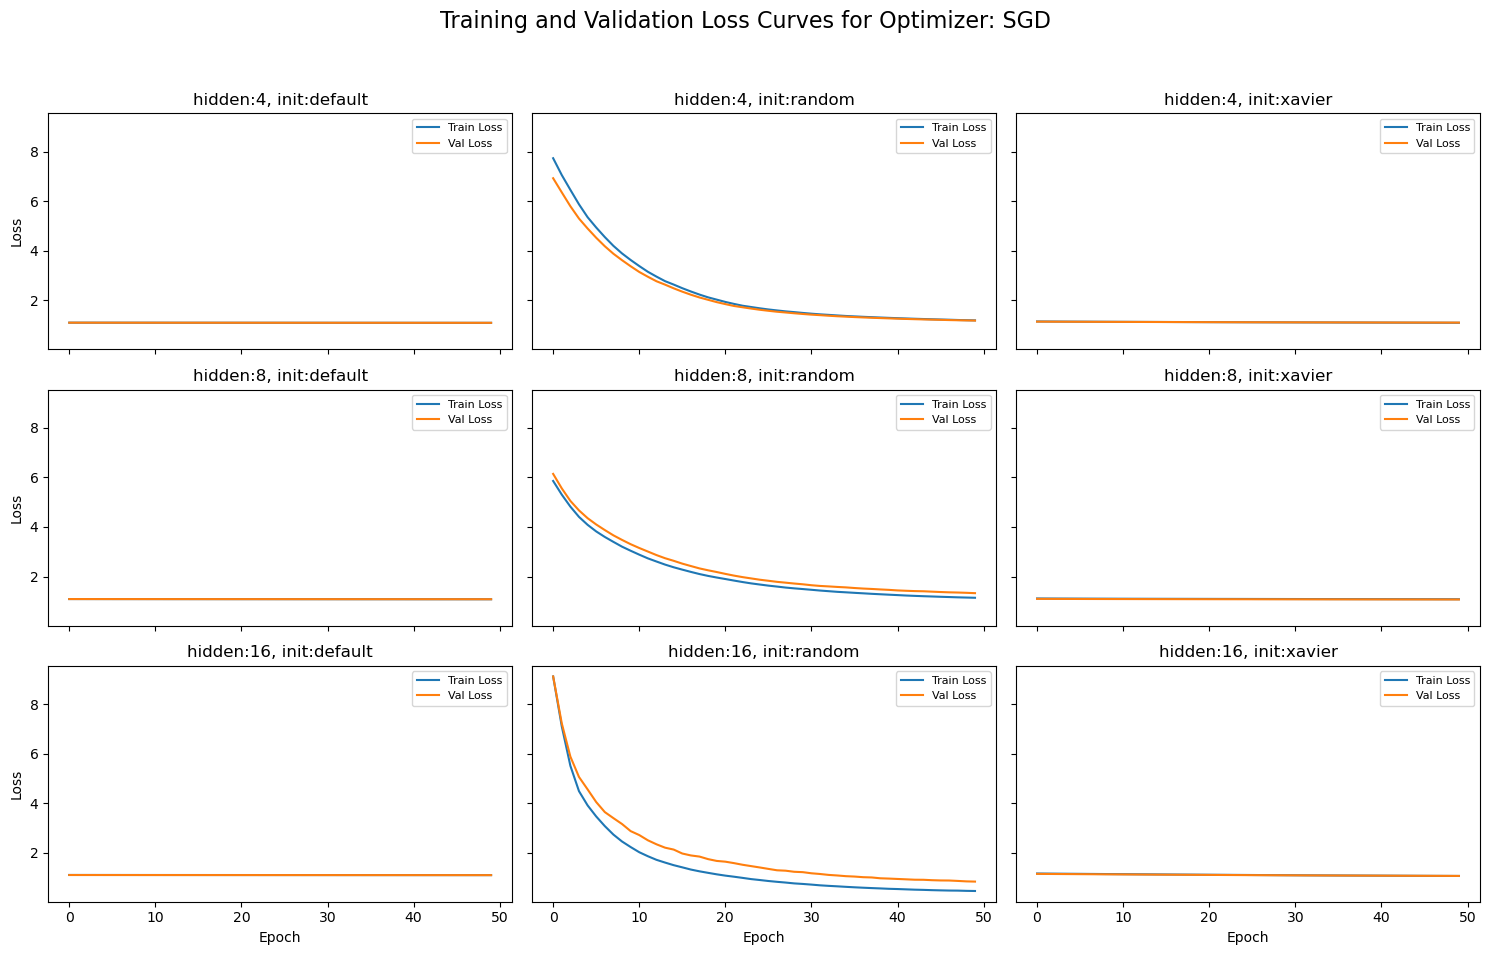

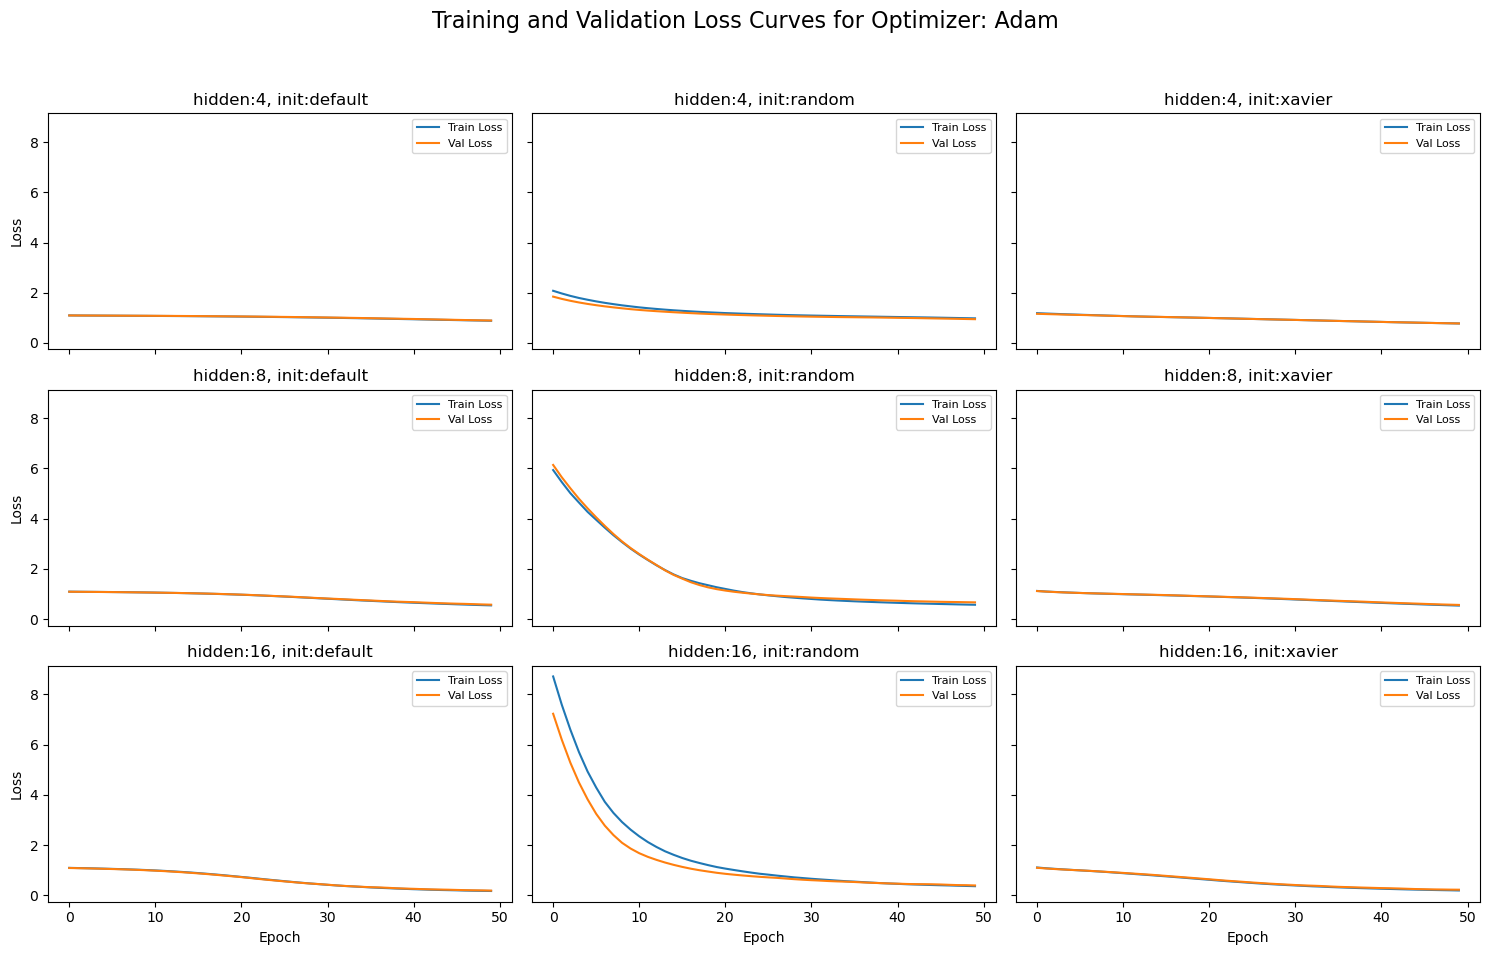

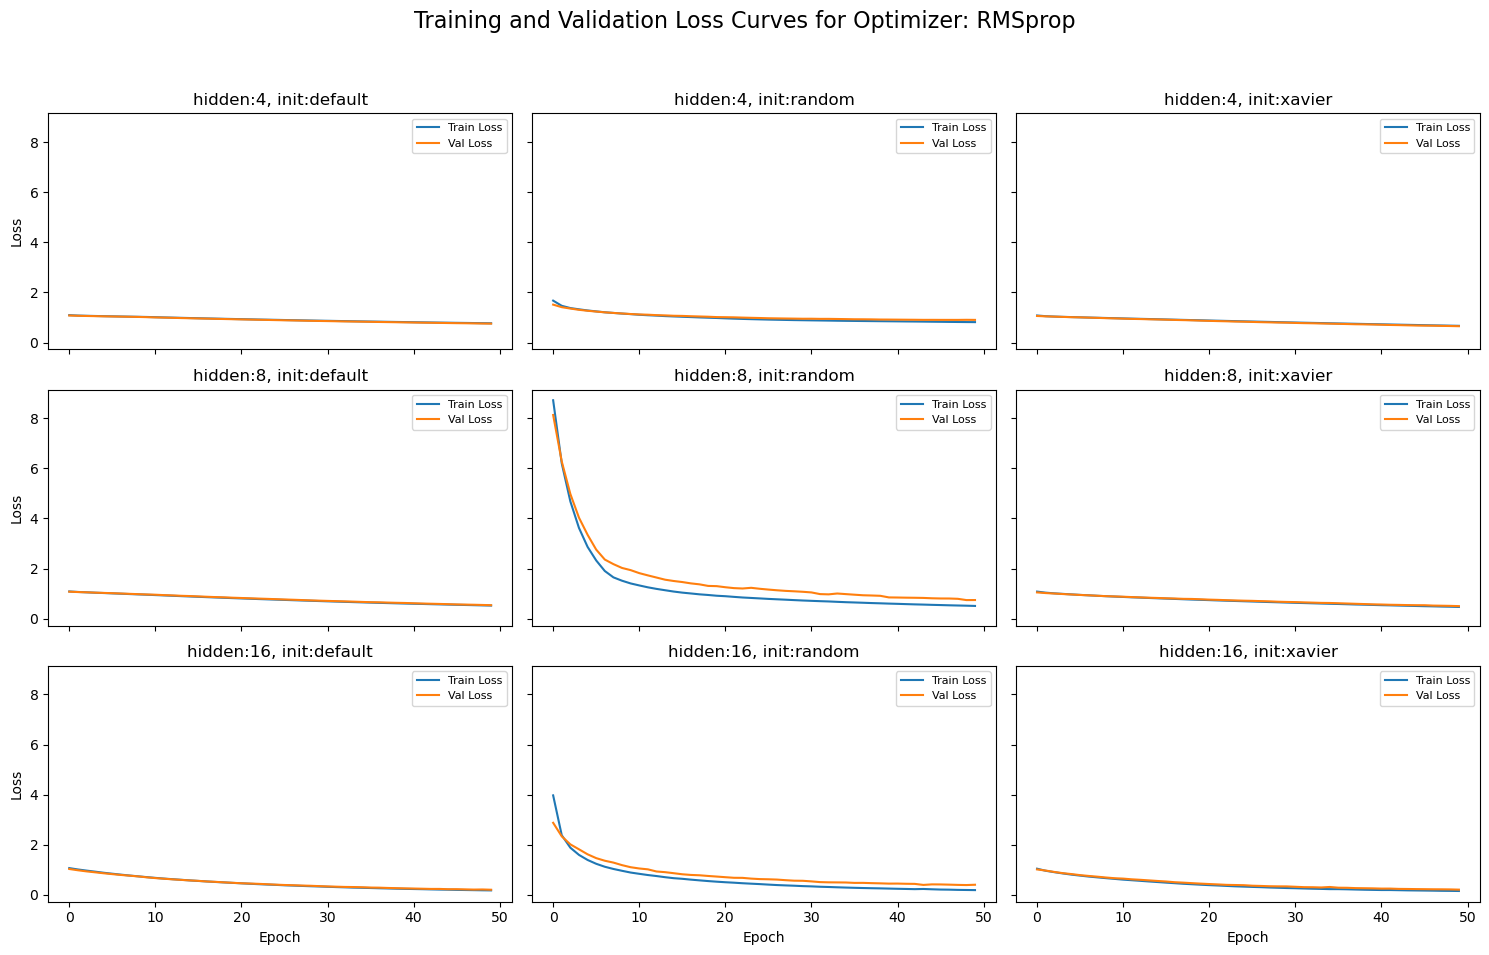

In [97]:
for opt_name in optimizer_names:
    fig, axes = plt.subplots(len(hidden_dims), len(init_methods), figsize=(15, 10), sharex=True, sharey=True)
    fig.suptitle(f"Training and Validation Loss Curves for Optimizer: {opt_name}", fontsize=16)
    for i, hidden_dim in enumerate(hidden_dims):
        for j, init_method in enumerate(init_methods):
            key = (hidden_dim, init_method, opt_name)
            if key in loss_curves:
                train_losses, val_losses = loss_curves[key]
                ax = axes[i, j]
                ax.plot(train_losses, label='Train Loss')
                ax.plot(val_losses, label='Val Loss')
                ax.set_title(f"hidden:{hidden_dim}, init:{init_method}")
                if i == len(hidden_dims)-1:
                    ax.set_xlabel("Epoch")
                if j == 0:
                    ax.set_ylabel("Loss")
                ax.legend(fontsize=8)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [98]:
final_dataset = TensorDataset(X_train_val_tensor, y_train_val_tensor)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

final_model = WineClassifier(input_dim, best_params['hidden_dim'], output_dim, best_params['init_method'])
if best_params['optimizer'] == 'SGD':
    final_optimizer = optim.SGD(final_model.parameters(), lr=lr)
elif best_params['optimizer'] == 'Adam':
    final_optimizer = optim.Adam(final_model.parameters(), lr=lr)
elif best_params['optimizer'] == 'RMSprop':
    final_optimizer = optim.RMSprop(final_model.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss()
final_history = train_model(final_model, final_optimizer, loss_fn, final_loader, test_loader, n_epochs)

In [99]:
final_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = final_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

test_accuracy = accuracy_score(y_true, y_pred)
print("\nFinal Model Test Accuracy: {:.4f}".format(test_accuracy))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Final Model Test Accuracy: 0.9722
Confusion Matrix:
[[12  0  0]
 [ 1 13  0]
 [ 0  0 10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.93      0.96        14
           2       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

